# Digital homodyne detection

In [237]:
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np
from tqdm import tqdm
from qutip import *
from scipy.interpolate import interp1d
from scipy.special import factorial, eval_hermite, comb
from scipy.integrate import quad
from joblib import Parallel, delayed

## Define basic operators

In [85]:
N=2

idc = qeye(N)
ida = qeye(2)

a  = tensor(destroy(N), ida)
sm = tensor(idc, destroy(2)) # note that this is not qutip's sigmam() definition

sx = tensor(idc, sigmax())
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())

proj0 = tensor(idc, basis(2,0).proj())
proj1 = tensor(idc, basis(2,1).proj())

N_cav = tensor(num(N), ida)

## Define unitaries

In [86]:
def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

def H_int(g, dt):
    Hint = (-1j) * g*np.sqrt(dt) * (a.dag() * sm + a * sm.dag())
    return Hint.expm()

def U_gint(gint):
    H = (-1j) * gint * (a.dag() * sm + a * sm.dag())
    return H.expm()

## Parameters and initial state

(0.3, 9, 3)

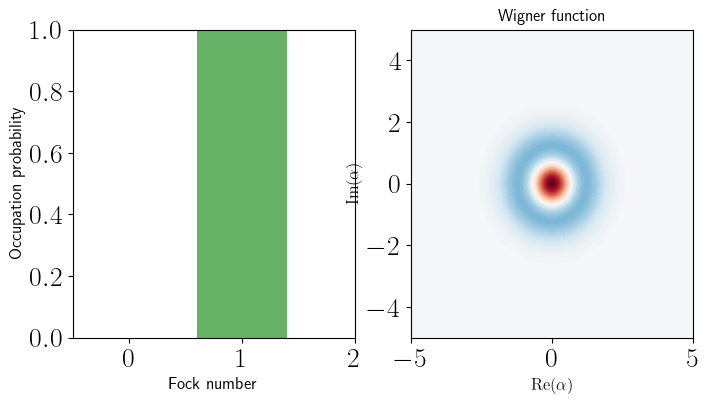

In [111]:
# number of qubit measurements per trajectory
Nmeas = 50

# number of trajectories
Ntrajs = 50

# interaction strength
g = 3

delta_t = 0.01

gamma = g**2

# effective interaction strength
gint = np.sqrt(gamma*delta_t)

# initialize state

initial_cavity = fock(N,1)
psi0 = tensor(initial_cavity, basis(2,0))

plot_wigner_fock_distribution(initial_cavity, alpha_max=5)

gint, gamma, g

### Settings

In [112]:
# homodyne angles for tomography
nangles = 10 # number of angles
thetas = np.linspace(0,np.pi, nangles) # list of all angles

# histogram parameters
Nbins = 30 # number of histogram bins
k = 4  # bin edge limit
dx =  2*k/Nbins # bin width

## Mode matching function

In [113]:
# weight measurement results with exponential filter
nsteps = np.arange(Nmeas)

nsteps = np.linspace(0,Nmeas-1,Nmeas)
weights=(gint/np.sqrt(2))*np.exp(-nsteps*(gint**2/2))

# Observe open system dynamics of cavity
No additional loss, effective decay rate $\gamma$.

In [185]:
U_int = H_int(g, delta_t)

prng = np.random.RandomState(187890)

n_cav_avg = np.zeros(Nmeas)
measurements = []
for j in tqdm(range(Ntrajs)):
        xrnd = prng.rand(Nmeas)
    
        results = []
        psi = ket2dm(psi0)
        n_cav = []
        
        for i in range(Nmeas):
            n_cav.append(expect(N_cav, psi).real)
            U = qbrotmat * U_int 
            #U = U_int
            psi = U * psi * U.dag()
            prob = expect(proj0,psi)
                       
            if prob > xrnd[i]:
                # measured g
                results.append(-1)
                psi = (proj0 * psi * proj0).unit()
            else:
                results.append(1)
                # measured e
                psi = (proj1 * psi * proj1 ).unit()
                # go back to g
                psi = qbfeedback * psi* qbfeedback.dag()
     
        measurement = np.sum(results*weights)
        measurements.append(measurement)
        n_cav_avg += n_cav

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.22s/it]


In [256]:
# solve master equation (ME) to compare with
tlist = nsteps*delta_t

c_op=[np.sqrt(gamma)*a] # decay rate gamma
sol = mesolve(0*a, psi0, tlist, c_ops=c_op, e_ops=[N_cav])

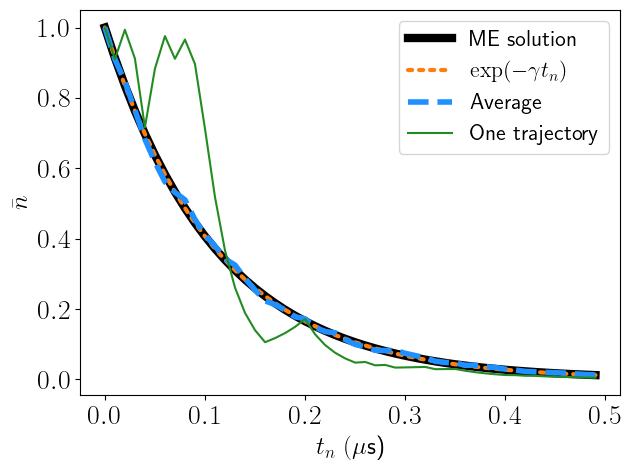

In [257]:
plt.plot(tlist, sol.expect[0],'k',linewidth=6, label='ME solution')
plt.plot(tlist, np.exp(-gamma*tlist),'C1',linestyle=':', dash_capstyle = 'round', linewidth=3, label='$\exp(-\gamma t_n)$')
plt.plot(tlist, n_cav_avg/Ntrajs,'dodgerblue', linestyle='--', linewidth=4, label='Average')
plt.plot(tlist, n_cav, 'forestgreen', label='One trajectory')

plt.xlabel(r'$t_n\ (\mu$s)')
plt.ylabel(r'$\bar n$')

plt.legend()
plt.tight_layout()

# Only loss

Note the longer timescale: consider 500 ns for one whole step (interact, measure and reset).

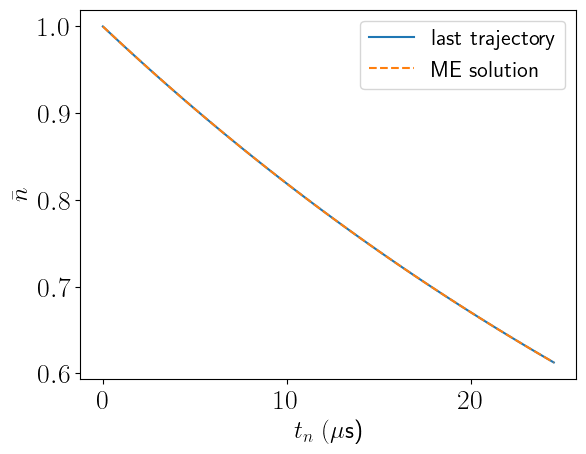

In [251]:
n_cav = []
psi = ket2dm(psi0) 

# CAVITY LOSS RATE
# T1 = 50 µs => kappa = 1/T1 = 1/50 = 0.02
kappa = 0.02

dt_total = 0.5 # consider 500 ns for one whole step (interact, measure, reset).

tlist_total = nsteps*dt_total

L = liouvillian(0*a, [np.sqrt(kappa*dt_total)*a])
op = L.expm()

for i in range(Nmeas):
            n_cav.append(expect(N_cav, psi).real)
                       
            # deterministic loss 
            vec_rho = operator_to_vector(psi)          
            psi = vector_to_operator(op*vec_rho)
            
c_op=[np.sqrt(kappa)*a] # decay rate gamma
sol = mesolve(0*a, psi0, tlist_total, c_ops=c_op, e_ops=[N_cav])            
       
plt.plot(tlist_total, n_cav, label='last trajectory')    
plt.plot(tlist_total, sol.expect[0], '--',label='ME solution')            

plt.xlabel(r'$t_n\ (\mu$s)')
plt.ylabel(r'$\bar n$')
plt.legend();

# Additional cavity decay
with rate $\kappa$. Neglecting total time, only considering interaction time $\Delta t$.

In [253]:
qbrotmat = rotateXY(np.pi/2,0) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state

prng = np.random.RandomState(12347890)

# cavity decay rate
kappa = 0.3

L = liouvillian(0*a, [np.sqrt(kappa*delta_t)*a])
op = L.expm()

n_cav_avg = np.zeros(Nmeas)
measurements = []
for j in tqdm(range(Ntrajs)):
        xrnd = prng.rand(Nmeas)
    
        results = []
        psi = ket2dm(psi0)
        n_cav = []
        
        for i in range(Nmeas):
            n_cav.append(expect(N_cav, psi).real)
            U = qbrotmat * U_int 
            psi = U * psi * U.dag()
            prob = expect(proj0,psi)
                       
            # deterministic loss 
            vec_rho = operator_to_vector(psi)          
            psi = vector_to_operator(op*vec_rho)

            if prob > xrnd[i]:
                # measured g
                results.append(-1)
                psi = (proj0 * psi * proj0).unit()
            else:
                results.append(1)
                # measured e
                psi = (proj1 * psi * proj1 ).unit()
                # go back to g
                psi = qbfeedback * psi* qbfeedback.dag()
     
        measurement = np.sum(results*weights)
        measurements.append(measurement)
        n_cav_avg += n_cav

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.22s/it]


Cumulative decay consistent with master equation solution.

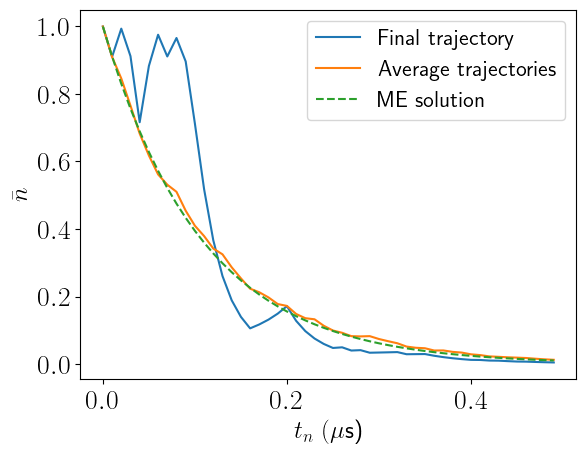

In [254]:
tlist = nsteps*delta_t

gamma_effective = gamma + kappa

c_op=[np.sqrt(gamma_effective)*a] # decay rate gamma
sol = mesolve(0*a, psi0, tlist, c_ops=c_op, e_ops=[N_cav])
             
plt.plot(tlist, n_cav, label='Final trajectory')
plt.plot(tlist, n_cav_avg/Ntrajs, label='Average trajectories')
plt.plot(tlist, sol.expect[0], '--',label='ME solution')
plt.xlabel(r'$t_n\ (\mu$s)')
plt.ylabel(r'$\bar n$')
plt.legend();

# Realistic readout with cavity decay
with rate $\kappa$. Interaction time is $\Delta t$ = ``delta_t`` and total time is ``dt_total`` set above.

In [259]:
qbrotmat = rotateXY(np.pi/2,0) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state

prng = np.random.RandomState(12347890)

L = liouvillian(0*a, [np.sqrt(kappa*dt_decay)*a])
op = L.expm()

n_cav_avg = np.zeros(Nmeas)
measurements = []
for j in tqdm(range(Ntrajs)):
        xrnd = prng.rand(Nmeas)
    
        results = []
        psi = ket2dm(psi0)
        n_cav = []
        
        for i in range(Nmeas):
            n_cav.append(expect(N_cav, psi).real)
            U = qbrotmat * U_int 
            psi = U * psi * U.dag()
            prob = expect(proj0,psi)
                       
            # deterministic loss 
            vec_rho = operator_to_vector(psi)          
            psi = vector_to_operator(op*vec_rho)

            if prob > xrnd[i]:
                # measured g
                results.append(-1)
                psi = (proj0 * psi * proj0).unit()
            else:
                results.append(1)
                # measured e
                psi = (proj1 * psi * proj1 ).unit()
                # go back to g
                psi = qbfeedback * psi* qbfeedback.dag()
     
        measurement = np.sum(results*weights)
        measurements.append(measurement)
        n_cav_avg += n_cav

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.22s/it]


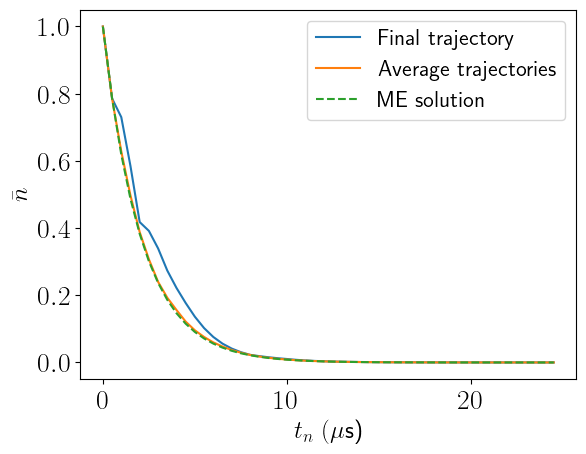

In [260]:
factor = dt_total/delta_t

# scale measurement rate to match the longer timescale
gamma_effective = gamma/factor + kappa


c_op=[np.sqrt(gamma_effective)*a] # decay rate gamma
sol = mesolve(0*a, psi0, tlist_total, c_ops=c_op, e_ops=[N_cav])
             
plt.plot(tlist_total, n_cav, label='Final trajectory')
plt.plot(tlist_total, n_cav_avg/Ntrajs, label='Average trajectories')
plt.plot(tlist_total, sol.expect[0], '--',label='ME solution')
plt.xlabel(r'$t_n\ (\mu$s)')
plt.ylabel(r'$\bar n$')
plt.legend();

# Tomography

Set cavity loss rate. Get good fidelity reconstruction even with very low efficiency!

In [224]:
# CAVITY LOSS RATE
kappa = 15

# Efficiency
eta = gamma/(gamma + kappa) # measurement efficiency
eta

0.375

Define function to get histograms.

In [225]:
# interaction unitary
U_int = H_int(g, delta_t)

# seed 
prng = np.random.RandomState(1234567890)

L = liouvillian(0*a, [np.sqrt(kappa*delta_t)*a])
op = L.expm()

# get measurement histogram for one homodyne angle
def get_hist(rotangl):
    
    ### simulate tomography ###
    
    qbrotmat = rotateXY(np.pi/2,rotangl) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
    
    qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state
    measurements = []

    for j in range(Ntrajs):
        xrnd = prng.rand(Nmeas)
    
        results = []
        psi = ket2dm(psi0)

        for i in range(Nmeas):
            U = qbrotmat * U_int 
            psi = U * psi * U.dag()
            prob = expect(proj0,psi)          
          
            # deterministic loss 
            vec_rho = operator_to_vector(psi)          
            psi = vector_to_operator(op*vec_rho)
            
            if prob > xrnd[i]:
                # measured g
                results.append(-1)
                psi = (proj0 * psi * proj0).unit()
            else:
                results.append(1)
                # measured e
                psi = (proj1 * psi * proj1 ).unit()
                # go back to g
                psi = qbfeedback * psi* qbfeedback.dag()
    
        measurements.append(np.sum(results*weights))
    
    
    ### create histogram ###    
    hist, bins = np.histogram(measurements,Nbins,[-k,k], density=True)
    
    return hist   

In [226]:
# get histograms for all angles in parallell

# NOTE: multiprocessing backend can give duplicate measurement results. loky should be ok though
# https://joblib.readthedocs.io/en/latest/auto_examples/parallel_random_state.html

b_all = Parallel(n_jobs=16, verbose=5, backend="loky")(delayed(get_hist)(rotangle) for rotangle in thetas)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    2.2s remaining:    5.1s
[Parallel(n_jobs=16)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    3.4s finished


Plot one histogram to compare to ideal statistics.

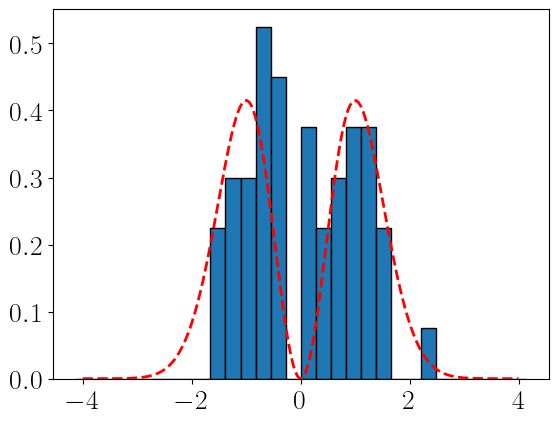

In [238]:
x_hist = np.linspace(-k,k,Nbins)
width = np.diff(x_hist)[3]
histogram = b_all[1]

plt.bar(x_hist,histogram , align='center', width=width, edgecolor='k',label='Samples' );

# ideal distribution from Wigner marginal
x=np.linspace(-k,k,200)
dx = np.diff(x)[0]
W = wigner(initial_cavity, x, x)

marginal = np.trapz(W,x)

# ideal cdf from marginal
cdf = np.cumsum(marginal)*dx
cdf_func = interp1d(x, cdf, fill_value="extrapolate")

plt.plot(x,marginal, 'r--',linewidth=2, label='$W$ marginal')

### Prepare data and operators

In [228]:
N_large = 25 # need some additional dimensions to properly construct the noise-compensated operators

# Load homodyne data into vector $\vec b$
b = np.concatenate([array for array in b_all])

### Define the harmonic oscillator wavefunction
#To create homodyne POVM operators.

def wavefunction(x,n):
    const = 1/(np.sqrt(2**n * factorial(n)) * (np.pi)**0.25 )
    rest = const* np.exp(-x**2/2)
    return float(rest*eval_hermite(n,x))

### Construct measurement operators
def get_Pis(theta, i):
    Pi = np.zeros((N_large,N_large),dtype=np.complex128)
    for m in range(N_large):
        wave_m = lambda x : wavefunction(x, m)
        for n in range(N_large):
            wave_n = lambda x: wavefunction(x, n)            
            func = lambda x: wave_m(x)*wave_n(x)
            Pi[n,m] = quad(func, -k + i*dx, -k + (i+1)*dx)[0]*np.exp(-1j*(n-m)*theta)
            
    return Pi*2 #

Pis = Parallel(n_jobs=16, verbose=5, backend="multiprocessing")(delayed(get_Pis)(theta,i) for theta in thetas for i in range(Nbins))

#The list `basis_dms` contains all $\Omega_k$
# funtions to construct vectors
def get_basis_vectors(N_large):
    # construct vectors
    basis_vectors = []
    for i in range(N_large):
        vector = fock(N_large, i)
        basis_vectors.append(np.real(vector.full()))
    
    return basis_vectors
        
def get_basis_dms(N_large, basis_vectors):    
    # construct operators
    basis_dms = []
    for vector1 in basis_vectors:
        for vector2 in basis_vectors:
            dm = np.outer(vector1, vector2)
            basis_dms.append(dm)
            
    return basis_dms

basis_vectors  = get_basis_vectors(N_large) # needed for the adjusted operators
basis_dms = get_basis_dms(N_large, basis_vectors)
        
### Construct noise adjusted measurement operators
def B(n,k, eta):
    return np.sqrt(comb(n+k,n) * eta**n * (1-eta)**k)

def get_adjusted_op(i,j):
        op = np.zeros((N_large,N_large), dtype=np.complex64)
        for n in range(N_large):
            for m in range(N_large):
                for k in range(N_large-max(m,n)):
                    op += B(m,k,eta)*B(n,k,eta)*Pis[i*Nbins + j][m,n] * np.outer(basis_vectors[n+k], basis_vectors[m+k])#
        return op

op_list = Parallel(n_jobs=-1, verbose=5, backend="multiprocessing")(delayed(get_adjusted_op)(i,j) for i in range(nangles) for j in range(Nbins))        

### Construct the matrix A in $A\vec\rho=\vec b$
#From `Pis` and `basis_dms`.

op_list_cut = [op[:N,:N] for op in op_list]

basis_vectors_cut = get_basis_vectors(N)
basis_dms_cut = get_basis_dms(N, basis_vectors_cut)

def func(index, a):
    return np.trace(op_list[index[0]][:N,:N] @ basis_dms_cut[index[1]])

A = np.zeros((len(Pis), N*N), dtype=np.complex64)
A_p = Parallel(n_jobs=16, verbose=5, backend="multiprocessing")(delayed(func)(idx,a) for idx, a in np.ndenumerate(A))

A = np.reshape(A_p, (len(Pis), N*N))

[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 228 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 298 out of 300 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.7s finished
[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1088 tasks      | elapsed:    0.1s
[Parallel(n_jobs

### Convex optimization

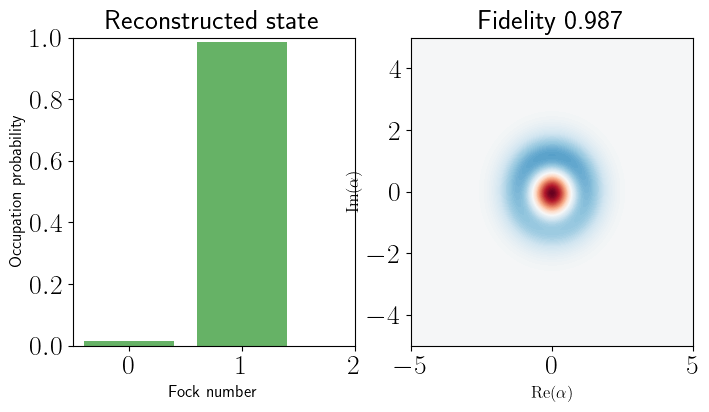

In [229]:
# Define the unknown state as a $N\times N$ Hermitian matrix

X = cp.Variable((N,N), hermitian=True)

#Set the cost function to $\|A\vec\rho - \vec b\|_2$ where the vectorized state is given by `cp.vec(X)`.

cost = cp.norm(A @ cp.vec(X) - b, 2) 

#Set the trace constraint and positive-semidefinite constraint, respectively.
constraints = [cp.trace(X) == 1, X >> 0 ]

#Set up and solve the problem!

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=False)

# Assign the optimized state X to a Qobj.
reconstructed_rho = Qobj(X.value)

### Visualize results

#Plot the reconstructed state 
alpha_max = 5
fig, ax = plot_wigner_fock_distribution(reconstructed_rho, alpha_max=5)
ax[0].set_title("Reconstructed state")

f=fidelity(reconstructed_rho, initial_cavity)**2
ax[1].set_title("Fidelity %.3f"%(f));

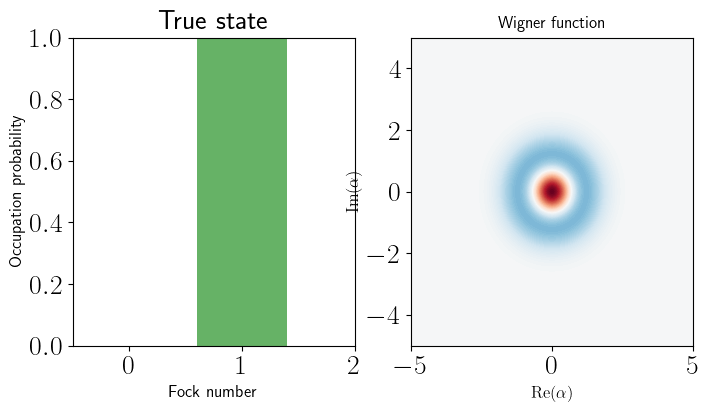

In [209]:
fig, ax = plot_wigner_fock_distribution(initial_cavity, alpha_max=5);
ax[0].set_title("True state");